In [14]:
import cf_xarray.units  # noqa: F401
import matplotlib.pyplot as plt
import pint_xarray  # noqa: F401
import plotly.express as px
import xarray as xr
from plotly import graph_objects as go

from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [15]:
path_to_forcing = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_product = "/Users/ash/Documents/Workspaces/Data/phd/SEAPODYM_LMTL/2025-01-10_-_CAFE_HOT/output"
path_to_obs = "../../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoDym_HOT_VGPM_by_epi_layer_depth"

In [16]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

## Loading


### Prediction


In [17]:
biomass = xr.open_zarr(path_to_forcing)["zooc"]
biomass = biomass.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
biomass.attrs["units"] = "g / m2"
biomass.load()

<xarray.DataArray 'zooc' (time: 9131)> Size: 73kB
array([0.28962967, 0.28384992, 0.28256553, ..., 0.21352965, 0.21802501,
       0.2183461 ])
Coordinates:
    latitude   float64 8B 22.75
    longitude  int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
Attributes:
    units:    g / m2

In [18]:
with xr.set_options(keep_attrs=True):
    # biomass = biomass.pint.quantify() / (layer_depth.interp_like(biomass)[0, 0, :, 0] * pint.Unit("m"))
    biomass = biomass.pint.quantify()
    biomass = biomass.pint.to("mg/m^2")
biomass

Magnitude,[289.6296670981368 283.84991870263184 282.565530170296 ... 213.52964655727487 218.0250064204472 218.34610355353038]
Units,milligram/meter2


### Forcing


In [19]:
forcing = xr.open_zarr(path_to_forcing)
layer_depth = forcing["pelagic_layer_depth"].load()
layer_depth.attrs["units"] = "meter"
layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 9131,
                                         depth: 3)> Size: 219kB
array([[[[117.28651056, 351.85237634, 820.98410789],
         [119.6003271 , 358.80719094, 837.21089488],
         [117.12780113, 351.38460116, 819.89820122],
         ...,
         [126.2427347 , 378.72271938, 883.69271249],
         [127.85488846, 383.56085128, 894.97611817],
         [128.3260049 , 384.98088309, 898.28729822]]]])
Coordinates:
  * depth      (depth) int32 12B 1 2 3
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
Attributes:
    units:    meter

In [20]:
layer_depth = layer_depth.interp_like(biomass)
layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 9131,
                                         depth: 3)> Size: 219kB
array([[[[117.28651056, 351.85237634, 820.98410789],
         [119.6003271 , 358.80719094, 837.21089488],
         [117.12780113, 351.38460116, 819.89820122],
         ...,
         [126.2427347 , 378.72271938, 883.69271249],
         [127.85488846, 383.56085128, 894.97611817],
         [128.3260049 , 384.98088309, 898.28729822]]]])
Coordinates:
  * depth      (depth) int32 12B 1 2 3
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 73kB 1998-01-01 1998-01-02 ... 2022-12-31
Attributes:
    units:    meter

### Observations


In [21]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.interp_like(biomass)
observations = observations.pint.quantify() * (layer_depth[0, 0, :, 0].pint.quantify())
observations

Magnitude,[[[[108.66651653679129]]] [[[109.45109250203718]]] [[[105.85729665965727]]] ... [[[nan]]] [[[nan]]] [[[nan]]]]
Units,milligram/meter2
Magnitude,[[[[188.46168452218322]]] [[[191.2333447912261]]] [[[186.35320240458867]]] ... [[[nan]]] [[[nan]]] [[[nan]]]]
Units,milligram/meter2


## Plot


### Taylor Diagram


In [22]:
biomass_pandas = biomass.pint.dequantify().to_dataframe().reset_index().set_index("time")["zooc"]
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [23]:
fig = go.Figure(
    layout={
        "title": "SeapoDym Monthly Biomass (VGPM npp) and Observations : HOT station",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [24]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [-0.5321542835134006, -0.46768061439310504]
norm STD [0.7383527296900956, 0.6478666654131259]
bias [-0.24543021251095729, -1.5057049335384944]
NRMSE [1.5267612416935425, 1.423278109296974]
name ['HOT Day', 'HOT Night']


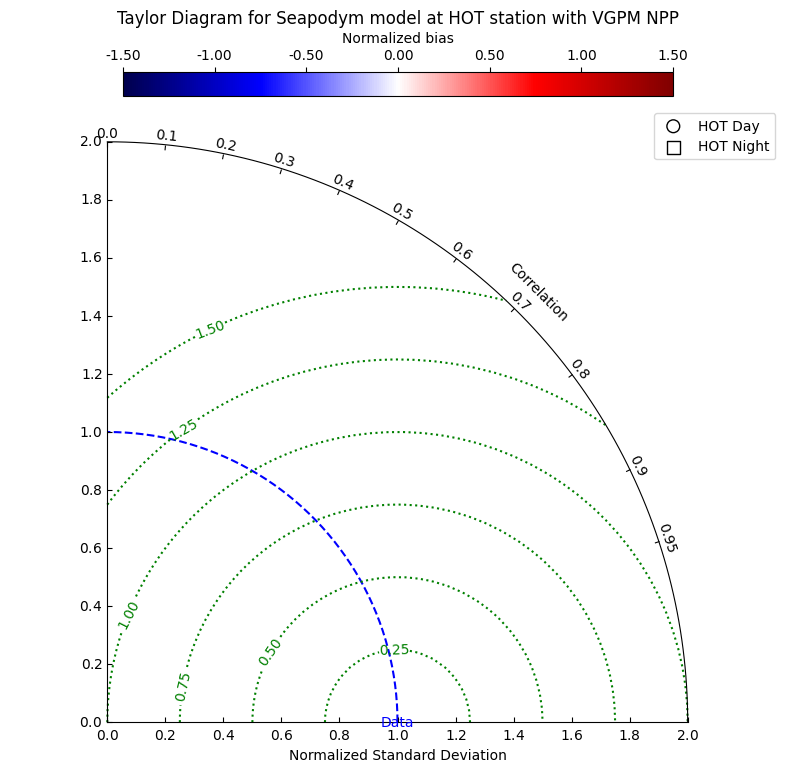

In [25]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred, monthly_pred]
all_obs = [monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title("Taylor Diagram for Seapodym model at HOT station with VGPM NPP")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [26]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,-0.532154,0.738353,-0.245430,1.526761
1,HOT Night,-0.467681,0.647867,-1.505705,1.423278
